# HDip in Science in Data Analytics for Business (FT) 
## Data Visualization and Machine Learning


#### Fabiane dos Santos Teixeira (2021225)                               
#### Nuno Alfredo Ribeiro Teixeira de Almeida (2021310)            
#### Valesca Soledad Bravo Bravo (2021235)
#### Thiago Medeiros de Souza (2019410)


## Title : <font color='blue'>a) What is the purpose of a recommendation system for online retail business in machine learning? Briefly compare Content and Collaborative filtering using any dataset of your choice. Train and test machine learning models for the user-user and item-item collaborative filtering. Justify your recommendations for the considered scenario by providing a conceptual insight. b) Use 3 visualisations performed using Tableau with specific features to summarise the most important aspects of the data and identify through your visualisation why this dataset is suitable for Machine Learning models in an online retail business. [Note: Tableau images must be pasted in the report]</font>

In [1]:
#nltk.download('stopwords')

### User-based Collaborative Filtering

In [1]:
# Importing necessary libraries
import pandas as pd
import nltk
import numpy as np
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

%matplotlib inline


In [3]:
#Here we will read the csv and put it in a pandas dataframe type
books_df = pd.read_csv("BX-Books.csv", sep=';', encoding="latin-1", error_bad_lines=False)
users_df = pd.read_csv("BX-Users.csv", sep=';', encoding="latin-1", error_bad_lines=False)
ratings_df = pd.read_csv("BX-Book-Ratings.csv", sep=',', encoding="latin-1", error_bad_lines=False)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/IPython/core/

In [4]:
# Let´s rename some of the columns
books_df = books_df[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]
books_df.rename(columns = {'Book-Title':'title', 'Book-Author':'author', 'Year-Of-Publication':'year', 'Publisher':'publisher'}, inplace=True)
users_df.rename(columns = {'User-ID':'user_id', 'Location':'location', 'Age':'age'}, inplace=True)
ratings_df.rename(columns = {'User-ID':'user_id', 'Book-Rating':'rating'}, inplace=True)

In [5]:
books_df.head()

,ISBN,title,author,year,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


### EXPLORING THE DATA

In [6]:
#Here we will check how many users have rated the books
ratings_df['user_id'].value_counts()

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
94504         1
59675         1
41234         1
45509         1
59078         1
Name: user_id, Length: 95513, dtype: int64

In [7]:
# We will be extracting from this dataset only users that have given more than 200 ratings
x = ratings_df['user_id'].value_counts() > 200
y = x[x].index  #user_ids
print(y.shape)
ratings_df = ratings_df[ratings_df['user_id'].isin(y)]

(815,)


In [8]:
#Now we are going to merge ratings with the books
rating_books = ratings_df.merge(books_df, on='ISBN')
rating_books.head()

,user_id,ISBN,rating,title,author,year,publisher
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc
1,3363,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc
2,11676,002542730X,6.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc
3,12538,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc
4,13552,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc


In [9]:
#With this piece of code we will extract the books that have received more than 50 ratings from users
number_rating_df = rating_books.groupby('title')['rating'].count().reset_index()
number_rating_df.rename(columns= {'rating':'number_of_ratings'}, inplace=True)
final_rating_df = rating_books.merge(number_rating_df, on='title')
final_rating_df.shape
final_rating_df = final_rating_df[final_rating_df['number_of_ratings'] >= 50]
final_rating_df.drop_duplicates(['user_id','title'], inplace=True)

In [10]:
#Checking the new dataset
final_rating_df.head()

,user_id,ISBN,rating,title,author,year,publisher,number_of_ratings
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,74
1,3363,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,74
2,11676,002542730X,6.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,74
3,12538,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,74
4,13552,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,74


In [12]:
final_rating_df.to_csv('tableu_recom.csv')

In [11]:
# We need to create a pivot table where columns wil be the users ids, the values will be the ratings and the index will be the book titles. To the users id that have not rated athe book, we will impute the value zero
book_pivot_df = final_rating_df.pivot_table(columns='user_id', index='title', values="rating")
book_pivot_df.fillna(0, inplace=True)

In [12]:
# In order to prepare the dataset for the modeling, as we have a huge amount o zeros, and on clustering this would increase the computer power in order to calculate the distance of zero values, we wull convert the pivot table to the sparse matrix and then feed it to the model.
book_sparse_df = csr_matrix(book_pivot_df)

In [13]:
# We will use the nearest neighbors model to train the dataset. We will use the algorithm brute that will find the distance of every point to every other point.
model_df = NearestNeighbors(algorithm='brute')
model_df.fit(book_sparse_df)

NearestNeighbors(algorithm='brute')

In [14]:
# Lets make predictions for the index 17
distances, suggestions = model_df.kneighbors(book_pivot_df.iloc[17, :].values.reshape(1, -1))

In [15]:
#With this code we print the suggested books based on the rating from users neighbors from the number 17 manually inputed above
for i in range(len(suggestions)):
  print(book_pivot_df.index[suggestions[i]])

Index(['Degree of Guilt', 'The Reef', 'Red Storm Rising', 'A Patchwork Planet',
       'A Fine Balance'],
      dtype='object', name='title')


## Content based Filtering - Item-item

In [17]:
# This dataset has been scraped from goodreads.com
# Reading the file
df_cont = pd.read_csv("data.csv")
#Checking the shape of the file
df_cont.shape

(2382, 8)

In [19]:
#Reading the first five records
df_cont.head()

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


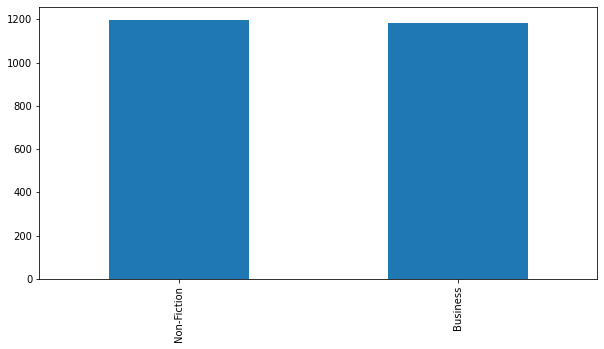

In [20]:
# Genre distribution
df_cont['genre'].value_counts().plot(x = 'genre', y ='count', kind = 'bar', figsize = (10,5)  )

In [22]:
# We will just pick a book title and description randomly for checking
df_cont['title'] [31], df_cont['Desc'][31]

('Triggers: Creating Behavior That Lasts—Becoming the Person You Want to Be',
 'Bestselling author and one of the world’s foremost executive coaches, Marshall Goldsmith examines the emotional and psychological triggers that cause us to react and behave in certain preset, often inappropriate ways at work and in life. Triggers shows us how to break that cycle and enact meaningful change.In Triggers, renown executive coach and psychologist Marshall Goldsmith discusses the emotional triggers that set off a reaction or a behavior in us that often works to our detriment. Do you find that at times you suddenly become defensive or enraged by an idle comment from a colleague? Or that your temper rises when another car cuts you off in traffic? Your reactions don’t occur in a vacuum. They are the result of emotional and psychological triggers that often happen only in specific settings—at meetings, or in competitive situations, or with a specific person who rubs you the wrong way, or when you fee

In [23]:
# Another onw
df_cont['title'] [556], df_cont['Desc'][556]

('The Power of Habit: Why We Do What We Do in Life and Business',
 'A young woman walks into a laboratory. Over the past two years, she has transformed almost every aspect of her life. She has quit smoking, run a marathon, and been promoted at work. The patterns inside her brain, neurologists discover, have fundamentally changed.Marketers at Procter & Gamble study videos of people making their beds. They are desperately trying to figure out how to sell a new product called Febreze, on track to be one of the biggest flops in company history. Suddenly, one of them detects a nearly imperceptible pattern—and with a slight shift in advertising, Febreze goes on to earn a billion dollars a year.An untested CEO takes over one of the largest companies in America. His first order of business is attacking a single pattern among his employees—how they approach worker safety—and soon the firm, Alcoa, becomes the top performer in the Dow Jones.What do all these people have in common? They achieved s

### Book description — Word count distribution

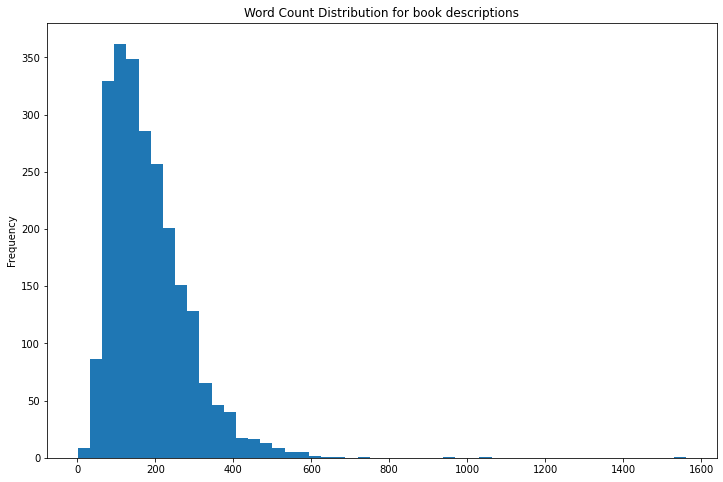

In [50]:
# Calculating the word count for book description
df_cont['word_count'] = df_cont['Desc'].apply(lambda x: len(str(x).split()))
# Plotting the word count
df_cont['word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Word Count Distribution for book descriptions')

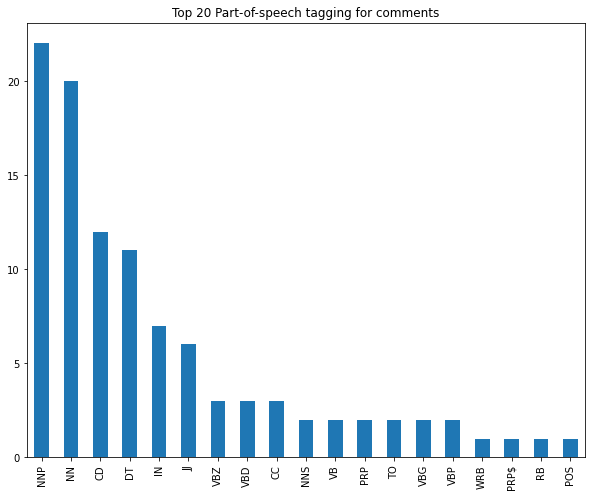

In [24]:
#The distribution of top part-of-speech tags in the book descriptions
from textblob import TextBlob
blob_cont = TextBlob(str(df_cont['Desc']))
pos = pd.DataFrame(blob_cont.tags, columns = ['word' , 'pos'])
pos = pos.pos.value_counts()[:20]
pos.plot(kind = 'bar', figsize=(10, 8), title = "Top 20 Part-of-speech tagging for comments")

## Bigram distribution for the book description

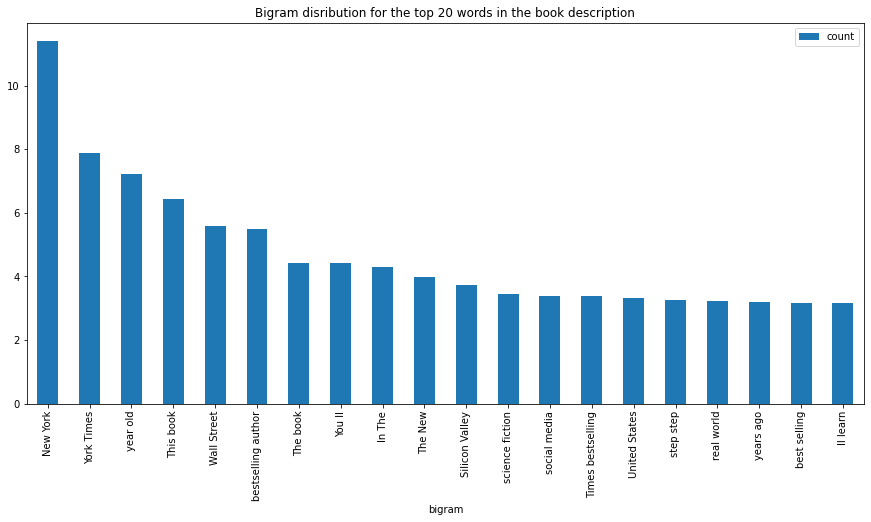

In [25]:
#Converting text descriptions into vectors using TF-IDF using Bigram
tf_cont = TfidfVectorizer(ngram_range=(2, 2), lowercase = False, stop_words='english')
tfidf_matrix_cont = tf_cont.fit_transform(df_cont['Desc'])
total_words_cont = tfidf_matrix_cont.sum(axis=0) 
#Finding the word frequency
freq_cont = [(word, total_words_cont[0, idx]) for word, idx in tf_cont.vocabulary_.items()]
freq_cont =sorted(freq_cont, key = lambda x: x[1], reverse=True)
#converting into dataframe 
bigram_cont = pd.DataFrame(freq_cont)
bigram_cont.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
bigram_cont = bigram_cont.head(20)
#Plotting the bigram distribution
bigram_cont.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the book description", figsize = (15,7), )

## Trigram distribution for the book description

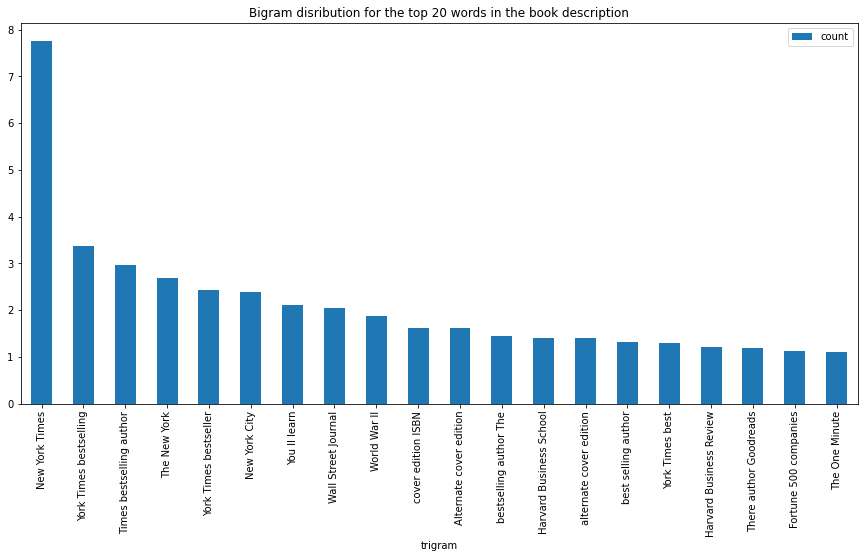

In [26]:
#Converting text descriptions into vectors using TF-IDF using Trigram
tf_cont = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix_cont = tf_cont.fit_transform(df_cont['Desc'])
total_words_cont = tfidf_matrix_cont.sum(axis=0) 
#Finding the word frequency
freq_cont = [(word, total_words_cont[0, idx]) for word, idx in tf_cont.vocabulary_.items()]
freq_cont=sorted(freq_cont, key = lambda x: x[1], reverse=True)
#converting into dataframe 
trigram_cont = pd.DataFrame(freq_cont)
trigram_cont.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
trigram_cont = trigram_cont.head(20)
#Plotting the trigramn distribution
trigram_cont.plot(x ='trigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the book description", figsize = (15,7), )

## Text Preprocessing

In [27]:
# Function for removing NonAscii characters
def _removeNonAscii_cont(s):
    return "".join(i for i in s if  ord(i)<128)
# Function for converting into lower case
def make_lower_case_cont(text):
    return text.lower()
# Function for removing stop words
def remove_stop_words_cont(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text
# Function for removing punctuation
def remove_punctuation_cont(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text
#Function for removing the html tags
def remove_html_cont(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)
# Applying all the functions in description and storing as a cleaned_desc
df_cont['cleaned_desc'] = df_cont['Desc'].apply(_removeNonAscii_cont)
df_cont['cleaned_desc'] = df_cont.cleaned_desc.apply(func = make_lower_case_cont)
df_cont['cleaned_desc'] = df_cont.cleaned_desc.apply(func = remove_stop_words_cont)
df_cont['cleaned_desc'] = df_cont.cleaned_desc.apply(func=remove_punctuation_cont)
df_cont['cleaned_desc'] = df_cont.cleaned_desc.apply(func=remove_html_cont)

## Recommendation based on book title

In [28]:
# Function for recommending books based on Book title. It takes book title and genre as an input.
def recommend_cont(title, genre):
    
    # Matching the genre with the dataset and reset the index
    data_cont = df_cont.loc[df_cont['genre'] == genre]  
    data_cont.reset_index(level = 0, inplace = True) 
  
    # Convert the index into series
    indices = pd.Series(data_cont.index, index = data_cont['title'])
    
    #Converting the book title into vectors and used bigram
    tf_cont = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix_cont = tf_cont.fit_transform(data_cont['title'])
    
    # Calculating the similarity measures based on Cosine Similarity
    sg_cont = cosine_similarity(tfidf_matrix_cont, tfidf_matrix_cont)
    
    # Get the index corresponding to original_title
       
    idx = indices[title]
# Get the pairwsie similarity scores 
    sig_cont = list(enumerate(sg_cont[idx]))
# Sort the books
    sig_cont = sorted(sig_cont, key=lambda x: x[1], reverse=True)
# Scores of the 5 most similar books 
    sig_cont = sig_cont[1:6]
# Book indicies
    book_indices = [i[0] for i in sig_cont]
   
    # Top 5 book recommendation
    rec = data_cont[['title', 'image_link']].iloc[book_indices]
       
    # It reads the top 5 recommend book url and print the images
    
    for i in rec['image_link']:
         response = requests.get(i)
         img = Image.open(BytesIO(response.content))
         plt.figure()
         print(plt.imshow(img))
         

AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)


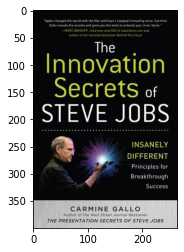

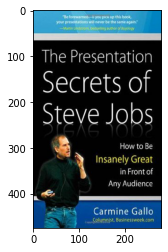

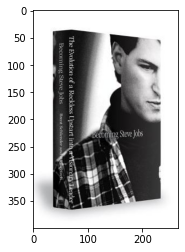

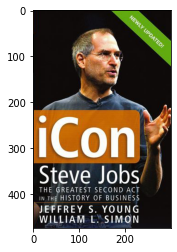

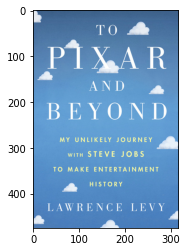

In [29]:
recommend_cont("Steve Jobs", "Business")

## The above model recommends five books similar to the title and genre

## Recommendation based on the book description

In [33]:
# Function for recommending books based on Book title. It takes book title and genre as an input.
def recommend_desc(title, genre):
    
    global rec
    # Matching the genre with the dataset and reset the index
    data_cont = df_cont.loc[df_cont['genre'] == genre]  
    data_cont.reset_index(level = 0, inplace = True) 
  
    # Convert the index into series
    indices = pd.Series(data_cont.index, index = data_cont['title'])
    
    #Converting the book description into vectors and used bigram
    tf_cont = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix_cont = tf_cont.fit_transform(data_cont['cleaned_desc'])
    
    # Calculating the similarity measures based on Cosine Similarity
    sg_cont = cosine_similarity(tfidf_matrix_cont, tfidf_matrix_cont)
    
    # Get the index corresponding to original_title
       
    idx = indices[title]
# Get the pairwsie similarity scores 
    sig_cont = list(enumerate(sg_cont[idx]))
# Sort the books
    sig_cont = sorted(sig_cont, key=lambda x: x[1], reverse=True)
# Scores of the 5 most similar books 
    sig_cont = sig_cont[1:6]
# Book indicies
    book_indices = [i[0] for i in sig_cont]
   
    # Top 5 book recommendation
    rec = data_cont[['title', 'image_link']].iloc[book_indices]
    
    # It reads the top 5 recommend book url and print the images
    
    for i in rec['image_link']:
        response = requests.get(i)
        img = Image.open(BytesIO(response.content))
        plt.figure()
        print(plt.imshow(img))

AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)


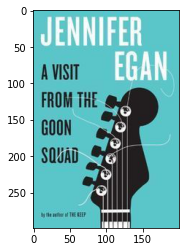

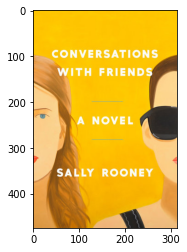

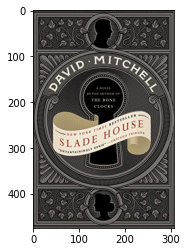

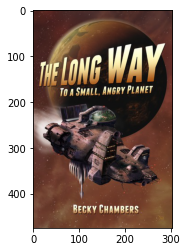

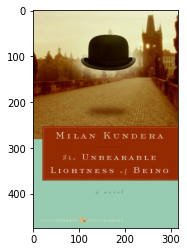

In [34]:
recommend_desc("Norwegian Wood", "Non-Fiction")

## The above model recommends five books similar to Norwegian Wood based on the description